In [1]:
from sklearn import datasets
import pandas as pd

housing = datasets.fetch_california_housing()

X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target, name="MedHouseVal")

df = pd.concat([X, y], axis=1)

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


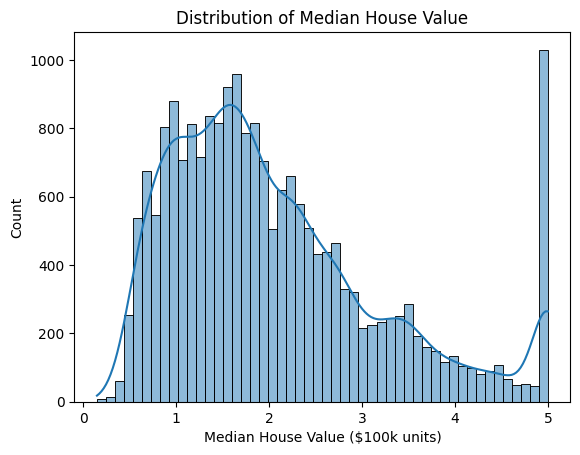

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(
    data=df,
    x="MedHouseVal",
    bins=50,
    kde=True
)

plt.title("Distribution of Median House Value")
plt.xlabel("Median House Value ($100k units)")
plt.ylabel("Count")
plt.show()


In [3]:
df["MedHouseVal"].max()


np.float64(5.00001)

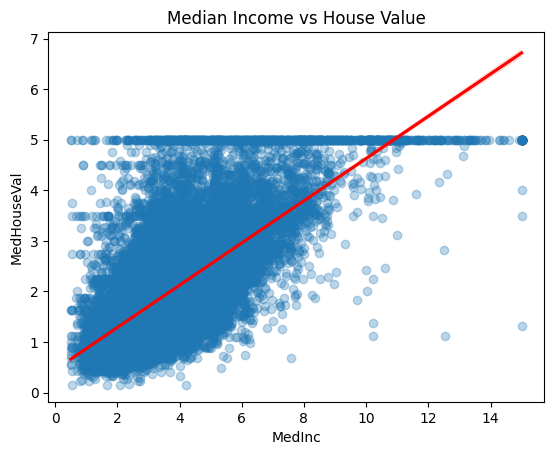

In [4]:
sns.regplot(
    x="MedInc",
    y="MedHouseVal",
    data=df,
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)
plt.title("Median Income vs House Value")
plt.show()


<Axes: xlabel='HouseAge', ylabel='MedHouseVal'>

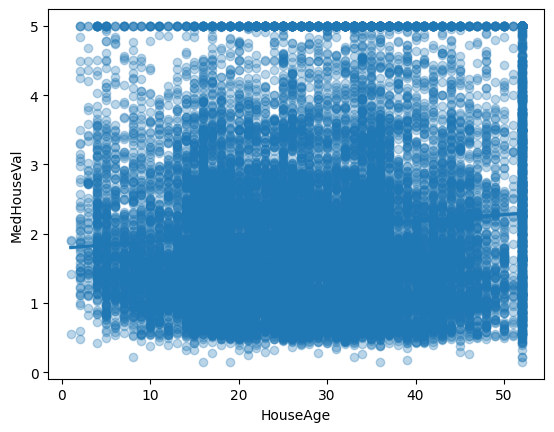

In [5]:
sns.regplot(x="HouseAge", y="MedHouseVal", data=df, scatter_kws={"alpha":0.3})


<Axes: xlabel='AveRooms', ylabel='MedHouseVal'>

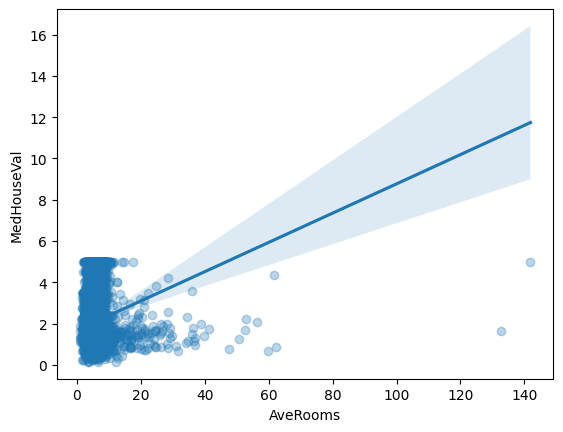

In [6]:
sns.regplot(x="AveRooms", y="MedHouseVal", data=df, scatter_kws={"alpha":0.3})


<Axes: xlabel='Population', ylabel='MedHouseVal'>

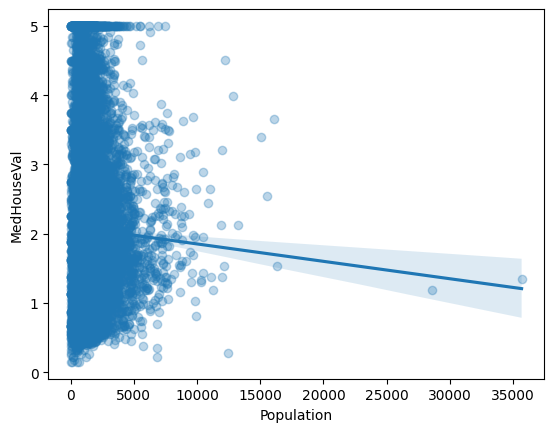

In [7]:
sns.regplot(x="Population", y="MedHouseVal", data=df, scatter_kws={"alpha":0.3})


<Axes: xlabel='AveOccup', ylabel='MedHouseVal'>

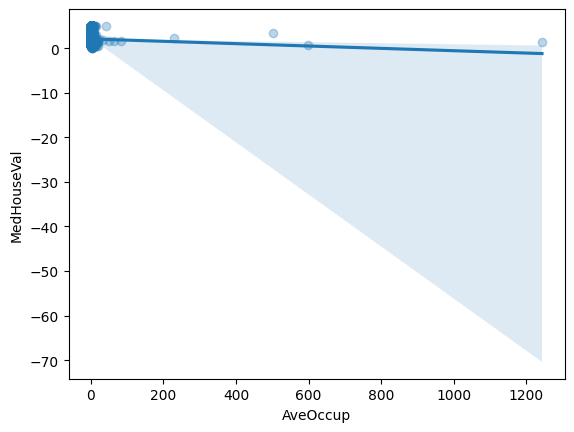

In [8]:
sns.regplot(x="AveOccup", y="MedHouseVal", data=df, scatter_kws={"alpha":0.3})


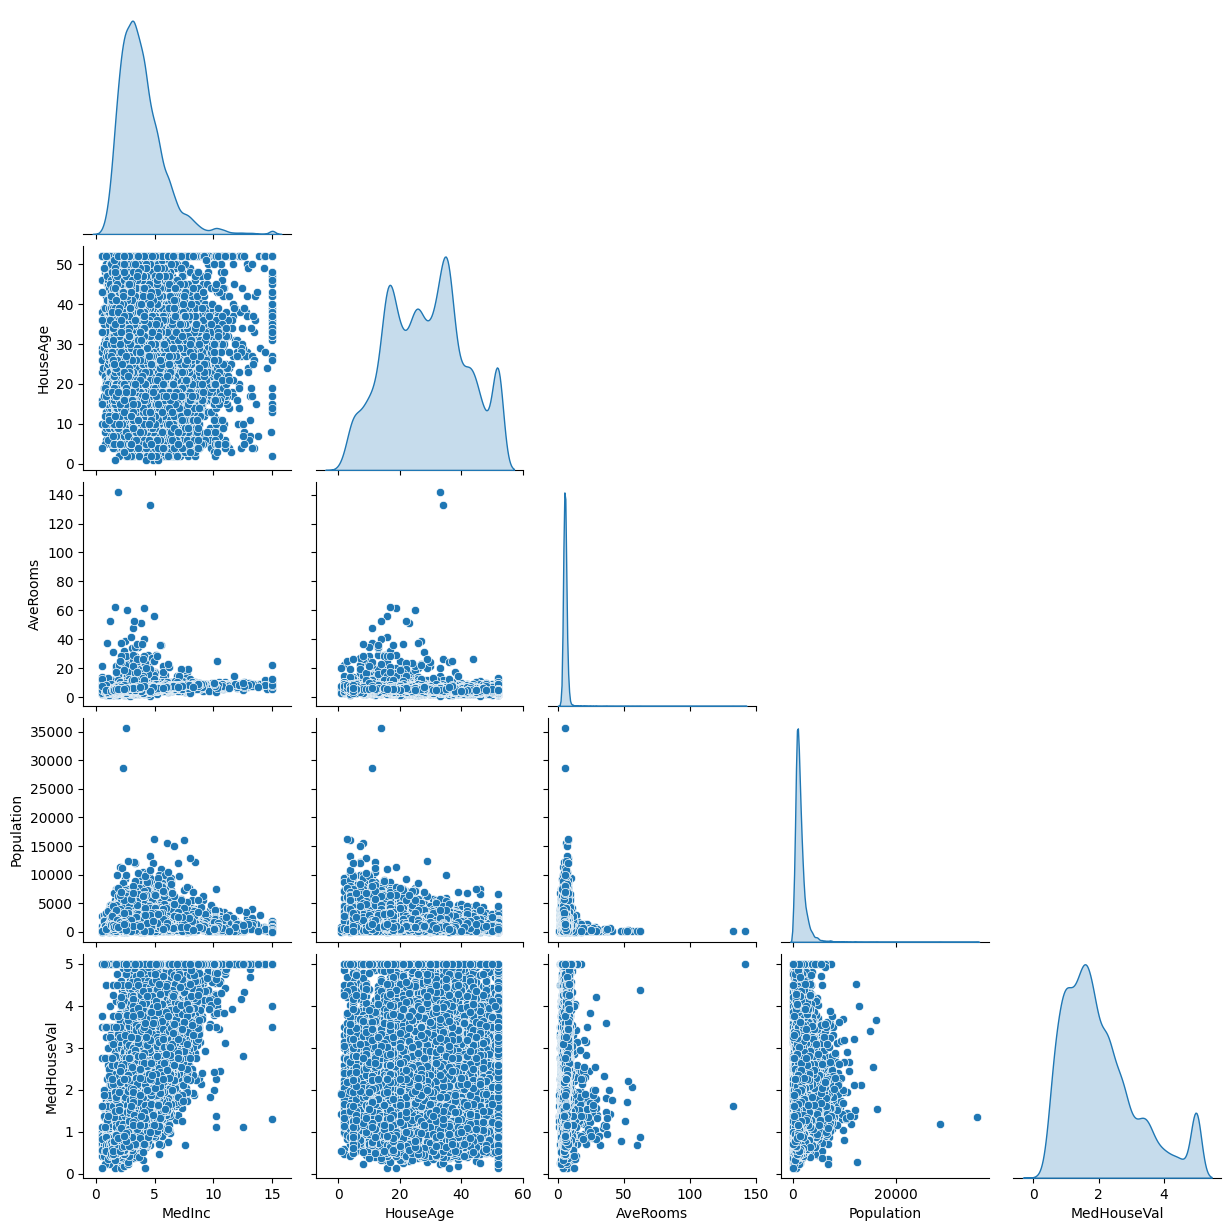

In [9]:
sns.pairplot(
    df[["MedInc", "HouseAge", "AveRooms", "Population", "MedHouseVal"]],
    diag_kind="kde",
    corner=True
)
plt.show()


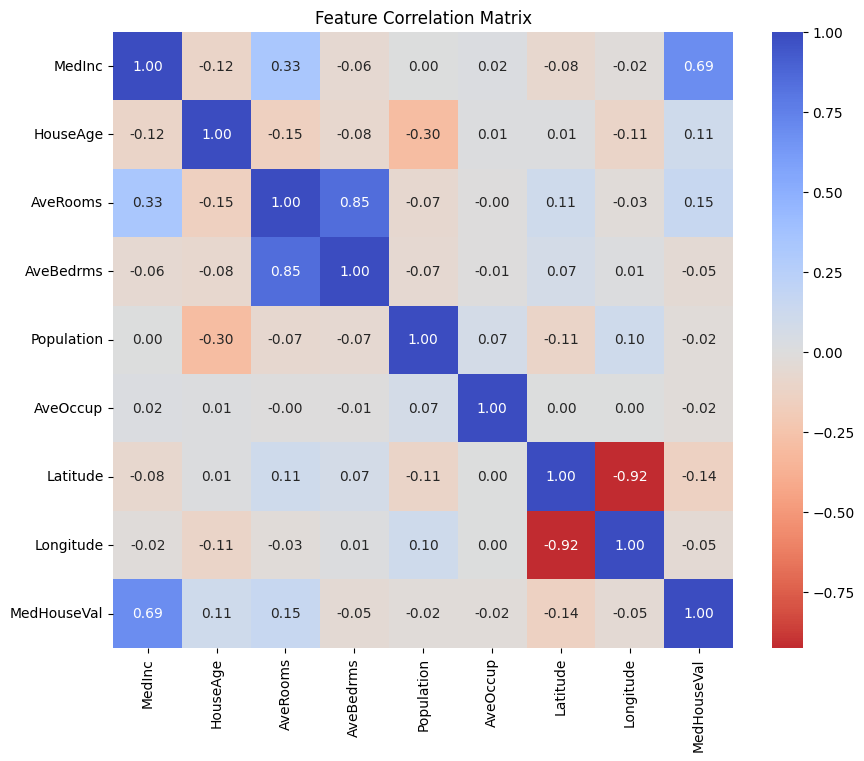

In [10]:
corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm_r",
    center=0,
)
plt.title("Feature Correlation Matrix")
plt.show()



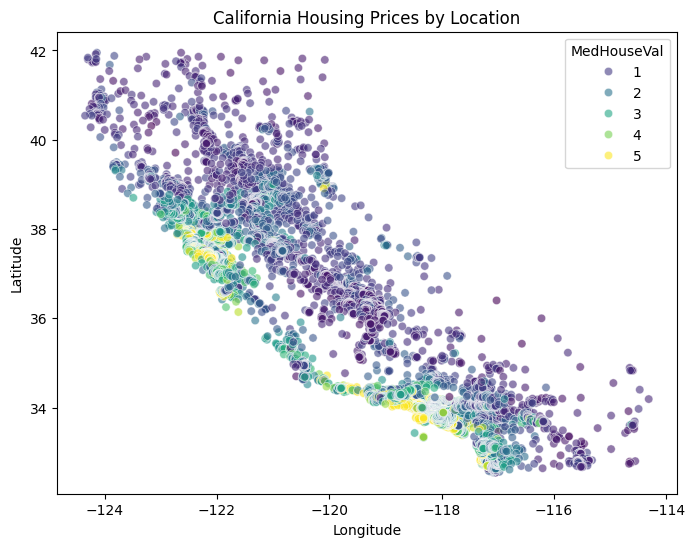

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="Longitude",
    y="Latitude",
    hue="MedHouseVal",
    palette="viridis",
    data=df,
    alpha=0.6
)
plt.title("California Housing Prices by Location")
plt.legend(title="MedHouseVal")
plt.show()


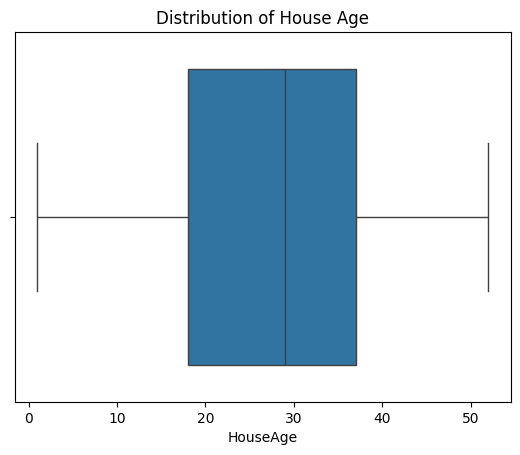

In [12]:
sns.boxplot(x=df["HouseAge"])
plt.title("Distribution of House Age")
plt.show()


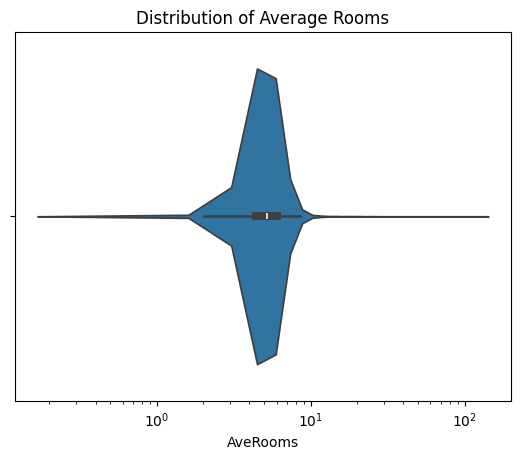

In [13]:
sns.violinplot(x=df["AveRooms"])
plt.xscale("log")
plt.title("Distribution of Average Rooms")
plt.show()



# Split the data into a training set and testing set

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, 
    random_state=42
)

# Get a base line using a basic linear regression

In [15]:
from sklearn.linear_model import LinearRegression

lrm = LinearRegression()
lrm.fit(x_train, y_train)

from sklearn.metrics import r2_score

y_pred = lrm.predict(x_test)
r2_score(y_test, y_pred)

0.5757877060324508

# Extract different features (multiplying different columns, squares or logs as examples)

In [16]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()
poly.fit(x_train)

x_train_poly = poly.transform(x_train)
x_test_poly  = poly.transform(x_test)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lrm = LinearRegression()
lrm.fit(x_train_poly, y_train)

y_pred = lrm.predict(x_test_poly)
r2_score(y_test, y_pred)

0.6456819712801447

# Use log to compress a feature set to reduce long tails like some rooms have tons of rooms

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import numpy as np

# Define which features to log
log_features = ["MedInc", "AveRooms", "AveBedrms", "Population", "AveOccup"]
linear_features = ["HouseAge", "Latitude", "Longitude"]

# Preprocessing step
preprocess = ColumnTransformer([
    ("log", FunctionTransformer(np.log1p), log_features),
    ("linear", "passthrough", linear_features)
])

# Pipeline with LinearRegression instead of Ridge
pipe = Pipeline([
    ("preprocess", preprocess),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# Fit and evaluate
pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)


0.7099069721760958

# Switch to using a Hist Gradient Boosting Regressor

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np

log_features = ["MedInc", "AveRooms", "AveBedrms", "Population", "AveOccup"]
linear_features = ["HouseAge", "Latitude", "Longitude"]

preprocess = ColumnTransformer([
    ("log", FunctionTransformer(np.log1p), log_features),
    ("linear", "passthrough", linear_features)
])

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", HistGradientBoostingRegressor())
])

# Fit and evaluate
pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)


0.835742870041113

# Switch to using a Random Forest Regressor

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Optional: log-transform only skewed features
log_features = ["MedInc", "AveRooms", "AveBedrms", "Population", "AveOccup"]
linear_features = ["HouseAge", "Latitude", "Longitude"]

preprocess = ColumnTransformer([
    ("log", FunctionTransformer(np.log1p), log_features),
    ("linear", "passthrough", linear_features)
])

# Pipeline with RandomForestRegressor
pipe_rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=200,   # number of trees
        max_depth=None,     # let trees grow fully
        random_state=42,
        n_jobs=-1           # use all CPU cores
    ))
])

# Fit and evaluate
pipe_rf.fit(x_train, y_train)
pipe_rf.score(x_test, y_test)


0.805925375691565

# Using a HistGradientBoostingRegressor but added in max_iteration and random_state

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np

# Optional log transforms for skewed features
log_features = ["MedInc", "AveRooms", "AveBedrms", "Population", "AveOccup"]
linear_features = ["HouseAge", "Latitude", "Longitude"]

preprocess = ColumnTransformer([
    ("log", FunctionTransformer(np.log1p), log_features),  # optional
    ("linear", "passthrough", linear_features)
])

pipe = Pipeline([
    ("preprocess", preprocess),  # optional, can even skip this for trees
    ("model", HistGradientBoostingRegressor(
        max_iter=200, random_state=42
    ))
])

pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)


0.8449928755881629

# Randomizing hyperparameters to improve performance

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# --------------------------
# Preprocessing
# --------------------------
log_features = ["MedInc", "AveRooms", "AveBedrms", "Population", "AveOccup"]
linear_features = ["HouseAge", "Latitude", "Longitude"]

preprocess = ColumnTransformer([
    ("log", FunctionTransformer(np.log1p), log_features),  # optional
    ("linear", "passthrough", linear_features)
])

# --------------------------
# Pipeline
# --------------------------
pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", HistGradientBoostingRegressor(
        random_state=42,
        early_stopping=True,        # stop if no improvement
        validation_fraction=0.1,    # 10% of training used as validation
        n_iter_no_change=20         # stop if 20 iterations no improvement
    ))
])

# --------------------------
# Hyperparameter search space
# --------------------------
param_dist = {
    "model__max_iter": [300, 400, 500, 600],          # more trees
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1], # smaller = slower but more precise
    "model__max_depth": [5, 7, 9, None],             # depth of trees
    "model__min_samples_leaf": [10, 20, 50, 100],    # leaf size
    "model__l2_regularization": [0.0, 0.1, 0.5, 1.0] # regularization
}

# --------------------------
# Randomized search
# --------------------------
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=100,       # try 50 random combinations
    cv=5,            # 3-fold cross-validation
    scoring='r2',
    verbose=2,
    n_jobs=-1,       # use all CPU cores
    random_state=42
)

# --------------------------
# Fit search
# --------------------------
random_search.fit(x_train, y_train)

# --------------------------
# Results
# --------------------------
print("Best parameters:", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)
print("Test set R²:", random_search.score(x_test, y_test))



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'model__min_samples_leaf': 50, 'model__max_iter': 600, 'model__max_depth': 9, 'model__learning_rate': 0.05, 'model__l2_regularization': 0.0}
Best CV R²: 0.8420504453235912
Test set R²: 0.84666464523177


# Cross validation to attempt to improve data

In [23]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# --------------------------
# Data split
# --------------------------
X = df.drop(columns="MedHouseVal")
y = df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# --------------------------
# Feature engineering
# --------------------------
def add_features(X):
    X = X.copy()
    X["RoomsPerHousehold"] = X["AveRooms"] / X["AveOccup"]
    X["BedroomsPerRoom"] = X["AveBedrms"] / X["AveRooms"]
    X["IncomePerRoom"] = X["MedInc"] / X["AveRooms"]
    X["PopulationDensity"] = X["Population"] / X["AveOccup"]
    return X

feature_transformer = FunctionTransformer(add_features)

# --------------------------
# Columns for preprocessing
# --------------------------
log_features = ["MedInc", "AveRooms", "AveBedrms", "Population", "AveOccup"]
linear_features = ["HouseAge", "Latitude", "Longitude",
                   "RoomsPerHousehold", "BedroomsPerRoom", 
                   "IncomePerRoom", "PopulationDensity"]

preprocess = ColumnTransformer([
    ("log", FunctionTransformer(np.log1p), log_features),  # only original skewed features
    ("linear", "passthrough", linear_features)             # engineered features as-is
])

# --------------------------
# Pipeline
# --------------------------
pipe = Pipeline([
    ("add_features", feature_transformer),
    ("preprocess", preprocess),
    ("model", HistGradientBoostingRegressor(
        max_iter=500,
        learning_rate=0.05,
        max_depth=9,
        min_samples_leaf=20,
        l2_regularization=0.5,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
    ))
])

# --------------------------
# Fit & evaluate on test set
# --------------------------
pipe.fit(X_train, y_train)
test_r2 = pipe.score(X_test, y_test)
print("Test set R²:", test_r2)

# --------------------------
# Cross-validation
# --------------------------
cv_scores = cross_val_score(pipe, X_train, y_train, cv=30, scoring='r2', n_jobs=-1)
print("Cross-validation R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())
print("CV R² Std Dev:", cv_scores.std())



Test set R²: 0.8380303835491452
Cross-validation R² scores: [0.88046688 0.83603527 0.81172768 0.88352148 0.8224061  0.85003055
 0.85240605 0.83451535 0.8451493  0.85273865 0.86323395 0.85630214
 0.83060702 0.82425361 0.87769041 0.87114186 0.86299732 0.82109593
 0.86779282 0.84762322 0.88043828 0.85198513 0.81994114 0.79655501
 0.84599275 0.86869797 0.84320149 0.88595963 0.8009535  0.81670275]
Mean CV R²: 0.8467387746601169
CV R² Std Dev: 0.024586176470757504
